<a href="https://colab.research.google.com/github/ggomes88/PythonFinance/blob/main/Clustering_IBRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. DEFININDO O PROBLEMA**

O Objetivo deste estudo é encontrar ativos semelhantes dentro do índice IBRA da B3 e assim encontrar pares de ativos para uma estratégia de Pair Trading.

Pair trading é uma estratégia de arbritragem estatística na qual um par de ações é negociado sem levar em conta a tendência do mercado.

 O IBrA é o indicador do desempenho médio das cotações de todos os ativos negociados no mercado a vista (lote-padrão) da B3 que atendam a critérios mínimos de liquidez e presença em pregão, de forma a oferecer uma visão ampla do mercado acionário.

Para essa análise iremos utilizar dados obtivos pela API do Yahoo Finance e bibliotecas do Python voltadas para Machine LEarning e Estatística


#**2. Carregando as Bibliotecas do Python e os Dados da Yahoo Finance**

### **2.1 Carregando as bibliotecas**

In [1]:
# Carregando Bibliotecas do Python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime as dt
import pandas_datareader as dr
!pip install yfinance
import yfinance as yf

#Importando os Algoritmos de Machine LEarning
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Outros pacotes
import matplotlib.ticker as ticker
from itertools import cycle

     |████████████████████████████████| 6.3MB 8.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.60-py2.py3-none-any.whl size=23819 sha256=c2964cb550c96a353d5ec38f729ecb8b8d8309aa200436782fde4d94dc9269c8
  Stored in directory: /root/.cache/pip/wheels/f0/be/a4/846f02c5985562250917b0ab7b33fff737c8e6e8cd5209aa3b
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


### **2.2 Carregando os dados**
Para essa análise iremos utilizar o período de janeiro de 2018 a julho de 2021.
Utilizei um csv contendo todos os ativos do IBRA que baixei direto do site da B3 e converti para a nomenclatura utilizada pelo Yahoo Finance. Transformei esses dados em lista para poder utilizar como argumento para a API do Yahoo Finance. Após baixar os dados, criei um dataset contendo apenas os preços de fechamento dos ativos.

In [2]:
#Baixando lista de ativos integrantes do IBRA do CSV com a nomenclatura do Yahoo Finance

ibra = pd.read_csv('ibra.csv',header=None)

#Convertendo dataframe para lista
ibra = ibra[0].values.tolist()

#Baixando dados do yfinance
inicio=dt.datetime(2018,1,1)
fim=dt.datetime(2021,7,1)
df=yf.download(ibra,inicio,fim)

#Limpando o DF para usar apenas os preços fechamento do dia
dataset = df['Adj Close']
type(dataset)

[*********************100%***********************]  178 of 178 completed


pandas.core.frame.DataFrame

# 3. Análise Exploratória

178 ativos foram baixados do Yahoo Finance, com 866 dias de negociação:

In [3]:
dataset.shape

(866, 178)

Vemos que alguns ativos não possuem dados em algumas datas. Podem ser ativos que foram adicionados após 2018 ou ativos que não constam na base de dados

In [4]:
set_option('display.width', 100)
dataset.head(5)

AALR3.SA   ABCB4.SA   ABEV3.SA  ...  WEGE3.SA  WIZS3.SA   YDUQ3.SA
Date                                         ...                               
2018-01-02  14.740349  13.699856  19.844748  ...  9.183080  8.606780  29.987968
2018-01-03  14.809646  13.757695  19.890491  ...  9.043611  8.535942  30.014536
2018-01-04  14.938338  13.716382  19.780704  ...  8.955523  8.465105  29.890579
2018-01-05  14.898741  13.914692  19.853895  ...  8.992227  8.585529  29.483299
2018-01-08  14.641355  14.046895  19.817299  ...  9.065634  8.550111  29.589546

[5 rows x 178 columns]

Vamos analisar os dados estatísticos do dataset:

In [5]:
set_option('precision', 3)
dataset.describe()

AALR3.SA  ABCB4.SA  ABEV3.SA  ...  WEGE3.SA  WIZS3.SA  YDUQ3.SA
count   860.000   860.000   860.000  ...   860.000   860.000   860.000
mean     13.473    15.016    16.296  ...    18.727     8.433    29.871
std       3.138     2.106     2.532  ...    11.842     2.247     6.872
min       8.252    10.288    10.695  ...     7.300     5.062    18.309
25%      11.110    13.325    14.766  ...     9.006     6.355    25.701
50%      12.944    14.813    16.567  ...    11.805     8.447    28.976
75%      15.146    16.671    17.762  ...    31.859     9.735    32.917
max      22.960    22.335    22.276  ...    45.849    17.740    54.680

[8 rows x 178 columns]

#3.2 Visualização dos Dados

Text(0.5, 1.0, 'Preço dos Ativos IBRA entre 2018 e 2021')

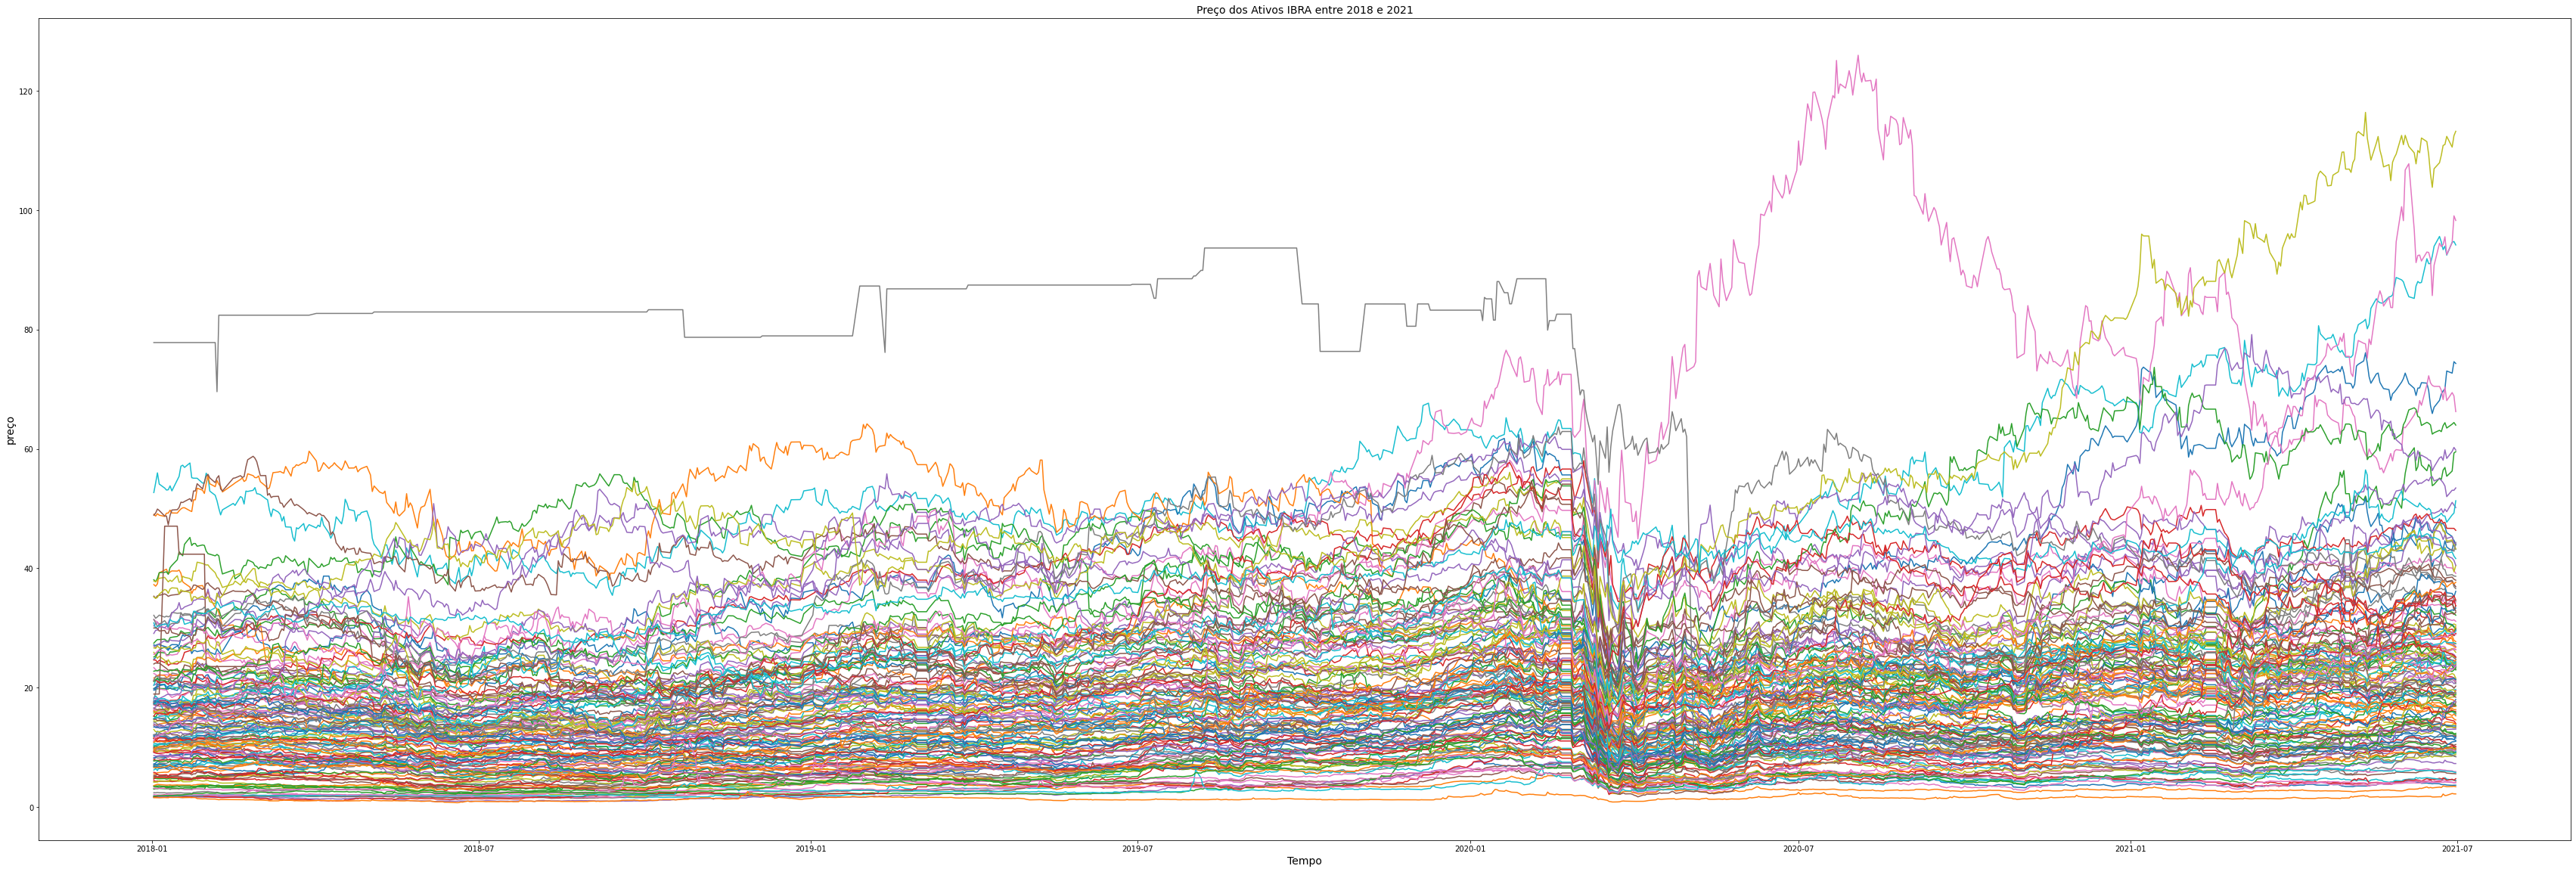

In [100]:
plt.figure(figsize=(60, 20))
plt.plot(dataset)
plt.xlabel('Tempo',fontsize=14)
plt.ylabel('preço',fontsize=14)
plt.title('Preço dos Ativos IBRA entre 2018 e 2021',fontsize=14)

#4. Preparação dos Dados
Para esta análise queremos agrupar os ativos de acordo com seu retorno anual e volatilidade. Para isto precisamos transformar a base para um dataframe contendo os ativos em linha com seu retorno e variancia em colunas. Além disso, como vimos, os ativos possuem preços bem divergentes, então precisamos padronizar a escala, pois a não padronização causaria uma distorção na analise. Outro ponto que devemos nos atentar antes da análise é fazer a limpeza dos dados, pois não podemos ter valores vazios no dataset.

### 4.1 Preparação dos dados

In [7]:
dataset.isnull().values.any()

True

In [9]:
#Removendo os ativos que possuem mais de 1% de valores faltando
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_fractions.loc[missing_fractions > 0.01].index))
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(866, 146)

In [10]:
# preenchendo os valores restantes com o valor da linha anterior
dataset=dataset.fillna(method='ffill')
dataset.head(2)

AALR3.SA  ABCB4.SA  ABEV3.SA  ...  WEGE3.SA  WIZS3.SA  YDUQ3.SA
Date                                      ...                              
2018-01-02     14.74    13.700    19.845  ...     9.183     8.607    29.988
2018-01-03     14.81    13.758    19.890  ...     9.044     8.536    30.015

[2 rows x 146 columns]

In [11]:
dataset.isnull().values.any()

False

Sucesso! Não temos mais valores faltando.

###4.2 Transformando os dados 
Para fazer o cluster iremos criar um novo dataframe contendo os ativos em linha e Retorno anual e Volatilidade como coluna.

In [12]:
#Calculando retorno médio anual e volatilidade em um periodo de um ano
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns

Todas as variaveis devem estar na mesma escala antes de aplicarmos a clusterização, caso contrário as discrepâncias de preço iriam dominar o resultado. Vamos usar o sklearn para padronizar o dataset em Z Scale (média=0 e desvio padrão = 1)


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset

In [14]:
X.head(2)

Returns  Volatility
AALR3.SA   -1.061      -0.222
ABCB4.SA   -0.795      -1.042

In [ ]:
ti

Antes de iniciar a análise dos modelos, vamos dar uma olhada no gráfico das Ações plotadas por seu retorno e volatilidade:

Text(0, 0.5, 'Volatilidade')

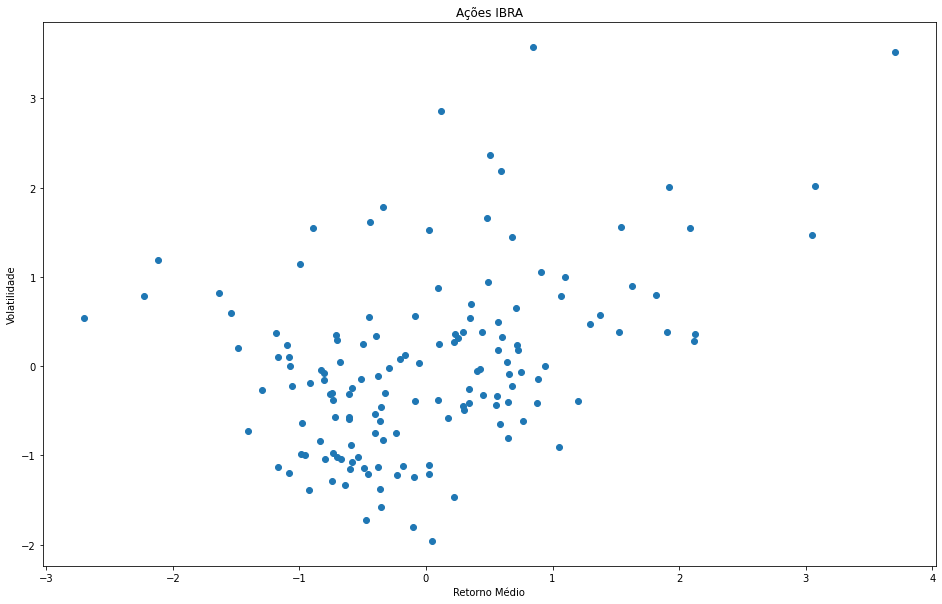

In [23]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1])
ax.set_title('Ações IBRA')
ax.set_xlabel('Retorno Médio')
ax.set_ylabel('Volatilidade')

#5. Analisando os modelos

Iremos analisar 4 modelos:

1.   K-Means
2.   Agrupamento Hierárquico
3.   Afinitty Propagation
4.   DBSCAN

Dentro de cada análise darei uma explicação sobre o funcionamento de cada algorítmo.

## 5.1 K-Means

O algoritmo KMeans agrupa os dados tentando separar as amostras em n **grupos de mesma variância** , um critério mínimo conhecido como inércia ou soma dos quadrados dentro do cluster. **Este algoritmo requer que o número de clusters seja especificado**. 

O algoritmo k-means divide um conjunto de N amostras X em K clusters C separados, cada um descrito pela média das amostras no cluster. As médias são comumente chamados de “centróides” do cluster; note que eles não são necessáriamente pontos de X, embora vivam no mesmo espaço.

Bsicamente o algoritmo possui três etapas. A primeira etapa escolhe os centróides iniciais, com o método mais básico sendo escolher K amostras do conjunto de dados X. Após a inicialização, o algorítmo faz um loop entre as duas outras etapas. A primeira etapa atribui cada amostra ao seu centróide mais próximo. A segunda etapa cria novos centróides tomando o valor médio de todas as amostras atribuídas a cada centróide anterior. A diferença entre o antigo e o novo centróide é calculada e o algoritmo repete essas duas últimas etapas até que esse valor seja menor que um limite. Em outras palavras, ele se repete até que os centróides não se movam significativamente.

Com tempo suficiente, o K-means sempre convergirá, no entanto, isso pode ser para um mínimo local. Isso é altamente dependente da inicialização dos centróides. Como resultado, o cálculo geralmente é feito várias vezes, com inicializações diferentes dos centróides.

### 5.1.1 Achando o número ideal de clusters

Como vimos, o algorítmo K-means exige a definição prévia do número de clusters que iremos trabalhar. Para isto iremos utilizar dois métodos:

1.   Método do Cotovelo(soma dos quadrados das distâncias dentro do cluster)
2.   Silhouette


### 5.1.1.1 Método do Cotovelo (soma dos quadrados das distâncias dentro do cluster)

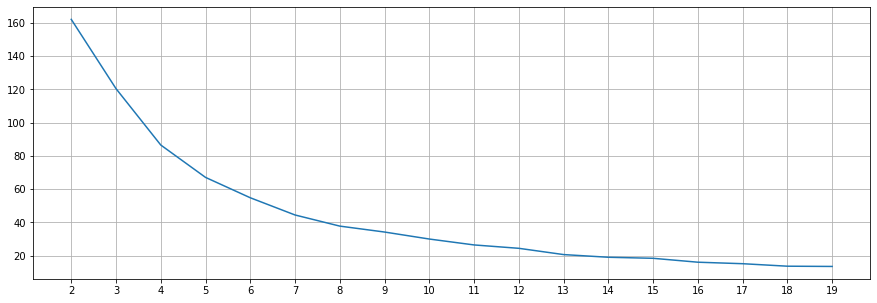

In [50]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)])
plt.grid(True)

### 5.1.1.2 Silhouette score

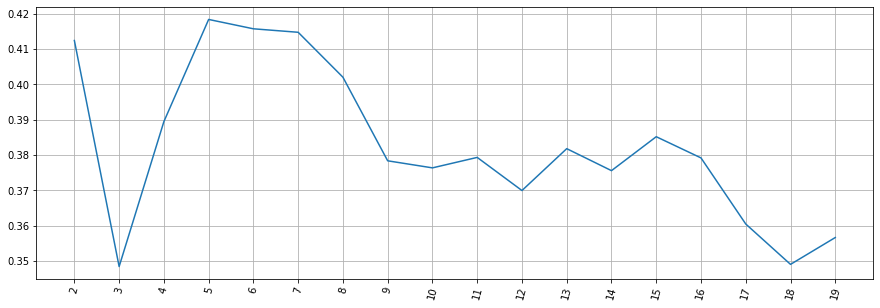

In [25]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

## 5.1.2 Executando o modelo

In [45]:
nclust=5
nclust2=7
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)
k_means2 = cluster.KMeans(n_clusters=nclust2)
k_means2.fit(X)

#Extraindo os labels
target_labels = k_means.predict(X)
target_labels2 = k_means2.predict(X)

5.1.3 Plotando os clusters

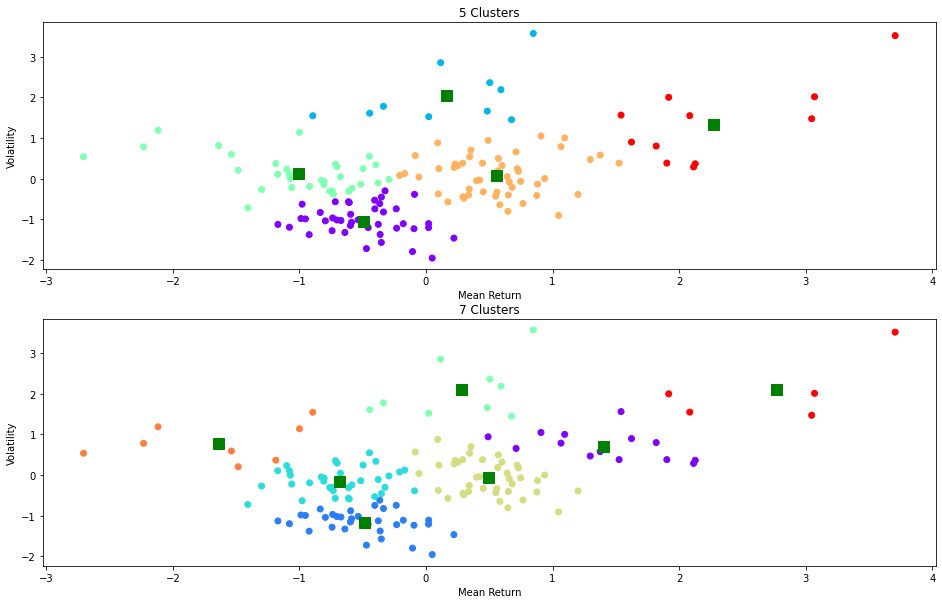

In [61]:
centroids = k_means.cluster_centers_
centroids2 = k_means2.cluster_centers_

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(211)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('%s Clusters' % nclust)
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

ax2 = fig.add_subplot(212)
scatter2 = ax2.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means2.labels_, cmap ="rainbow", label = X.index)
ax2.set_title('%s Clusters' % nclust2)
ax2.set_xlabel('Mean Return')
ax2.set_ylabel('Volatility')
plt.plot(centroids2[:,0],centroids2[:,1],'sg',markersize=11)

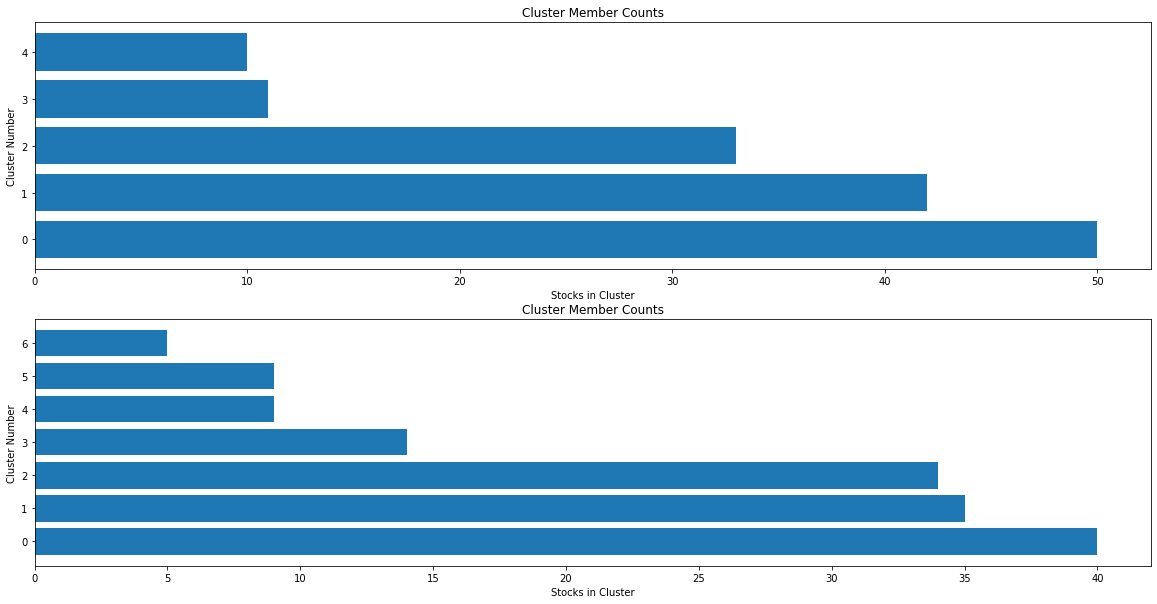

In [89]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series2 = pd.Series(index=X.index, data=k_means2.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series_all2 = pd.Series(index=X.index, data=k_means2.labels_.flatten())
clustered_series2 = clustered_series2[clustered_series2 != -1]

fig = plt.figure(figsize=(20,10))
fig.add_subplot(211)
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
ax2 = fig.add_subplot(212)
plt.barh(
    range(len(clustered_series2.value_counts())), # cluster labels, y axis
    clustered_series2.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()


# 5.2 Agrupamento Hierárquico

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z1= linkage(X, method='single')
Z2= linkage(X, method='complete')
Z3= linkage(X, method='average')

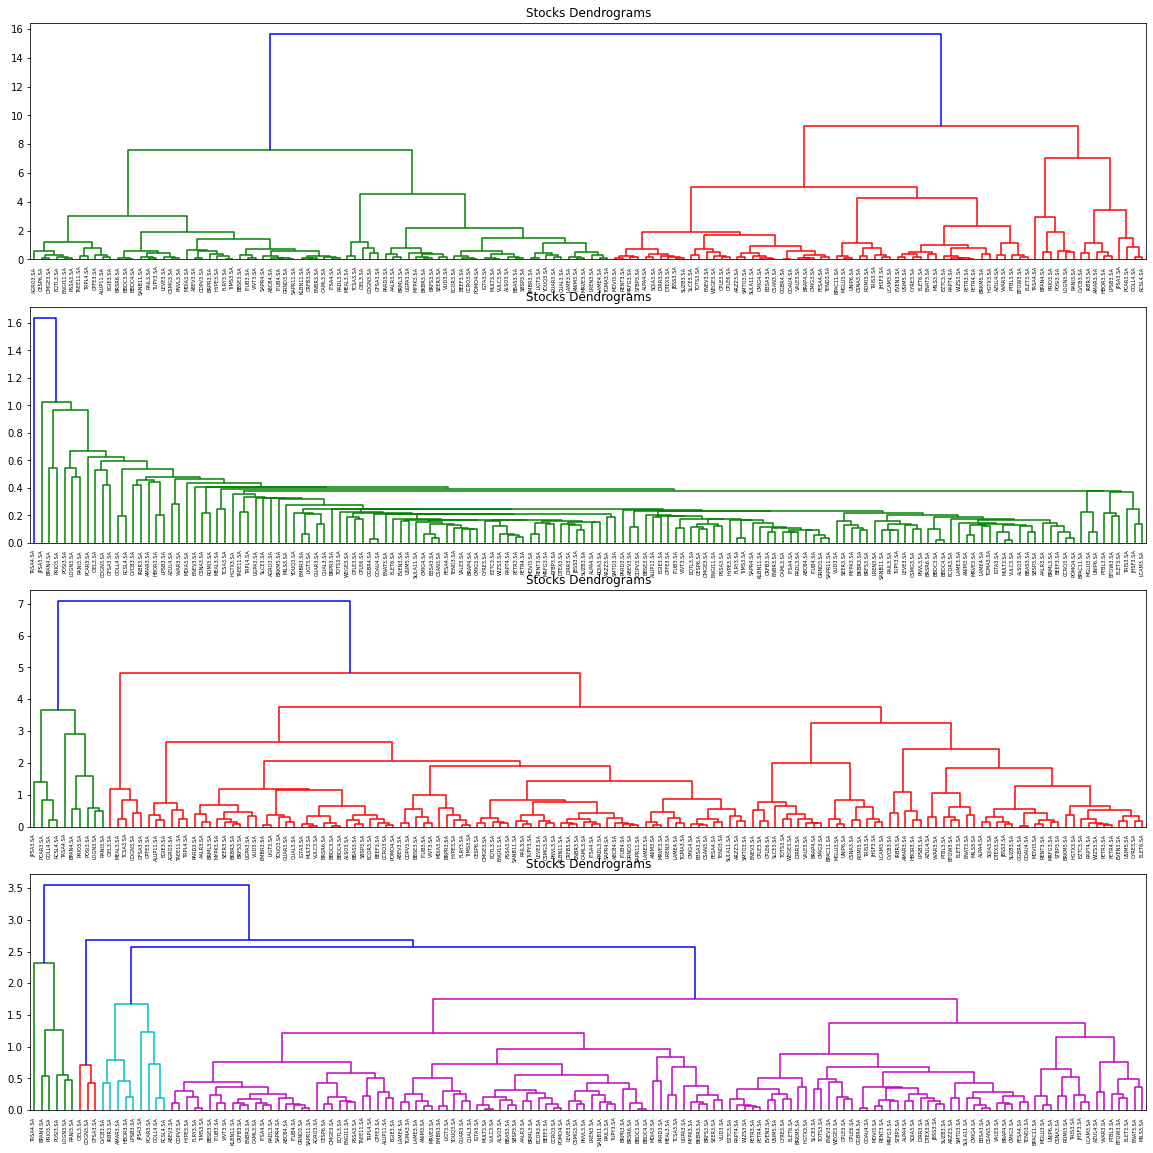

In [96]:
#Plot Dendogram
fig = plt.figure(figsize=(20,20))
fig.add_subplot(411)
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
fig.add_subplot(412)
plt.title("Stocks Dendrograms")
dendrogram(Z1,labels = X.index)
fig.add_subplot(413)
plt.title("Stocks Dendrograms")
dendrogram(Z2,labels = X.index)
fig.add_subplot(414)
plt.title("Stocks Dendrograms")
dendrogram(Z3,labels = X.index)
plt.show()

5.2.2 Vamos executar o modelo

In [97]:
nclust = 5
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

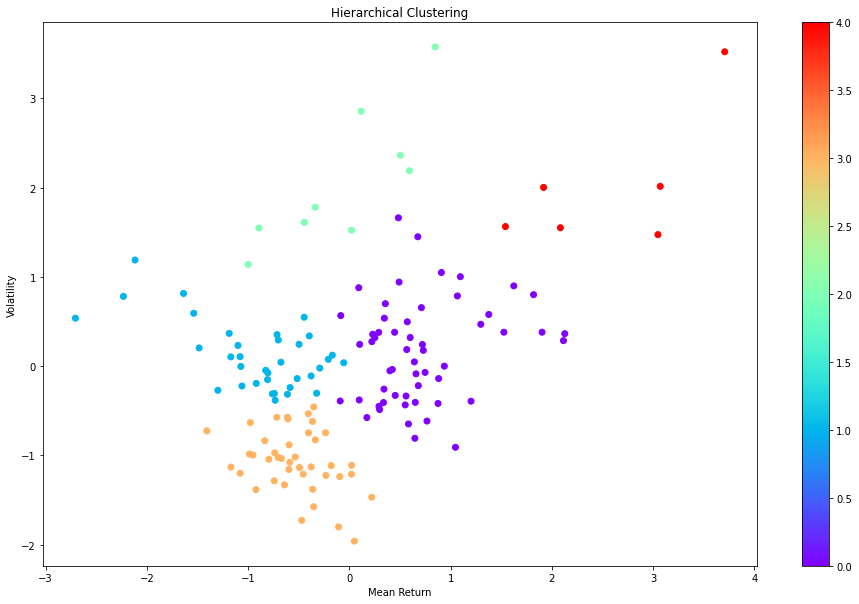

In [98]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)